In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 데이터 로드 및 ID 제거
df_final = pd.read_csv('final_features.csv')
df_final.drop('ID', axis = 1, inplace = True)

# 0. 데이터 준비
X = df_final.drop(columns=['Segment']).copy()
y = df_final['Segment'].copy()

encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
label_map = {cls: idx for idx, cls in enumerate(encoder.classes_)}
inv_map = {v: k for k, v in label_map.items()}

X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

In [5]:
# Model 1: E vs not-E
# ----------------------------
y_train_e = (y_train == label_map['E']).astype(int)
y_val_e   = (y_val == label_map['E']).astype(int)

X_train1, y_train1 = SMOTE(random_state=42).fit_resample(X_train, y_train_e)

weights1 = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train1)
class_weights1 = {0: weights1[0], 1: weights1[1]}

model1 = LGBMClassifier(
    random_state=42,
    verbose=-1,
    class_weight=class_weights1
)
model1.fit(X_train1, y_train1)
pred1 = model1.predict(X_val)

In [6]:
# Model 2: A/B vs C/D
# (이전에 분기된 데이터셋 필요, 여기에선 가정)
# X_train2, y_train2_bin, X_val2, y_val2 준비 필요

# E가 아닌 데이터만 선택
mask_abcd = y_train != label_map['E']

# 입력값 (특성)
X_train2 = X_train[mask_abcd]

# 출력값 (이진 분류: A/B → 1, C/D → 0)
y_train2 = y_train[mask_abcd]

# A/B vs C/D로 이진 레이블 생성
y_train2_bin = np.where(np.isin(y_train2, [label_map['A'], label_map['B']]), 1, 0)

# 검증 데이터도 같은 방식으로 나눔
mask_abcd_val = y_val != label_map['E']
X_val2 = X_val[mask_abcd_val]
y_val2 = y_val[mask_abcd_val]


X_train2_sm, y_train2_sm = SMOTE(random_state=42).fit_resample(X_train2, y_train2_bin)

model2 = LGBMClassifier(
    random_state=42,
    verbose=-1
)
model2.fit(X_train2_sm, y_train2_sm)
pred2 = model2.predict(X_val2)

In [8]:
# Model 3: A vs B (Rule-based)

# Model 2 예측 결과 중 A/B로 분류된 샘플 (pred2 == 1)
mask_ab = pred2 == 1

# 해당 인덱스를 X_val2, y_val2에서 추출
X_val3 = X_val2[mask_ab]
y_val3 = y_val2[mask_ab]


feature_name = '포인트_적립포인트_R3M'

if feature_name not in X_val3.columns:
    raise ValueError(f"{feature_name} 컬럼이 존재하지 않습니다. Rule을 다른 컬럼으로 바꿔주세요.")

pred3 = (X_val3[feature_name] > 10).astype(int).values

In [9]:
# Model 4: C vs D
mask_train_cd = np.isin(y_train, [label_map['C'], label_map['D']])
X_train4 = X_train[mask_train_cd]
y_train4 = (y_train[mask_train_cd] == label_map['D']).astype(int)

mask_val_cd = pred2 == 0
X_val4 = X_val2[mask_val_cd]
y_val4 = y_val2[mask_val_cd]
y_val4_bin = (y_val4 == label_map['D']).astype(int)

X_train4_sm, y_train4_sm = SMOTE(random_state=42).fit_resample(X_train4, y_train4)

weights4 = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train4_sm)
class_weights4 = {0: weights4[0], 1: weights4[1]}

model4 = LGBMClassifier(
    random_state=42,
    verbose=-1,
    class_weight=class_weights4
)
model4.fit(X_train4_sm, y_train4_sm)
pred4 = model4.predict(X_val4)

In [10]:
# 최종 예측 통합

final_preds = []
true_labels = []
ab_idx = 0
cd_idx = 0

for i in range(len(X_val)):
    if pred1[i] == 1:
        final_preds.append(label_map['E'])
    else:
        if pred2[ab_idx + cd_idx] == 1:
            final_preds.append(label_map['B'] if pred3[ab_idx] == 1 else label_map['A'])
            ab_idx += 1
        else:
            final_preds.append(label_map['D'] if pred4[cd_idx] == 1 else label_map['C'])
            cd_idx += 1
    true_labels.append(y_val[i])

=== 최종 다단계 모델 성능 ===
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        32
           B       0.00      0.00      0.00         5
           C       0.27      0.17      0.21      4253
           D       0.51      0.52      0.52     11642
           E       0.93      0.95      0.94     64068

    accuracy                           0.84     80000
   macro avg       0.34      0.33      0.33     80000
weighted avg       0.83      0.84      0.84     80000



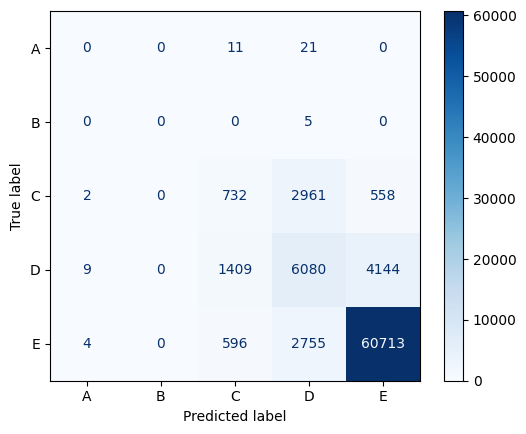

In [13]:
# 성능 평가

print("=== 최종 다단계 모델 성능 ===")
print(classification_report(true_labels, final_preds, target_names=encoder.classes_))

cm = confusion_matrix(true_labels, final_preds, labels=range(len(encoder.classes_)))
ConfusionMatrixDisplay(cm, display_labels=encoder.classes_).plot(cmap='Blues')